In [1]:
## Installing packages
install.packages("prospectr")
install.packages("pls")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
## Packages
library(tidyverse)
library(prospectr)
library(pls)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
prospectr version 0.2.6 -- 'chicago'

check the github repository at: https://github.com/l-ramirez-lopez/prospectr/


Attaching package: ‘pls’


The following object is masked from ‘package:prospectr’:

    msc


The following object is masked from ‘package:stats’:

    loadings




In [3]:
## Reading files
list.files()
train <- read_csv("/kaggle/input/ss4gg-hackathon-mir-soil-spectroscopy/train.csv")
test <- read_csv("/kaggle/input/ss4gg-hackathon-mir-soil-spectroscopy/test.csv")
submission <- read_csv("/kaggle/input/ss4gg-hackathon-mir-soil-spectroscopy/sample_submission.csv")

[1] "__notebook__.ipynb"

Rows: 57268 Columns: 1682
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (2): dataset, id
dbl (1680): clay_perc, sand_perc, silt_perc, texture_sum, 650, 652, 654, 656...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 250 Columns: 1679
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (3): unique_id, instrument, sample_id
dbl (1676): 650, 652, 654, 656, 658, 660, 662, 664, 666, 668, 670, 672, 674,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 250 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): unique_id
dbl (1): clay_perc

ℹ Use `spec()` to retrieve the full column specification for th

In [4]:
## Overview
test %>%
    select(1:10) %>%
    glimpse()

Rows: 250
Columns: 10
$ unique_id  <chr> "U1", "U2", "U3", "U4", "U5", "U6", "U7", "U8", "U9", "U10"…
$ instrument <chr> "INST1", "INST1", "INST1", "INST1", "INST1", "INST1", "INST…
$ sample_id  <chr> "S1139", "S1239", "S1444", "S1484", "S1498", "S1603", "S180…
$ `650`      <dbl> 2.53446, 2.60417, 2.42569, 2.53700, 2.44423, 2.43868, 2.814…
$ `652`      <dbl> 2.52495, 2.60600, 2.41961, 2.52715, 2.44196, 2.42384, 2.818…
$ `654`      <dbl> 2.52004, 2.60204, 2.41259, 2.51345, 2.42782, 2.40877, 2.804…
$ `656`      <dbl> 2.52020, 2.58584, 2.40228, 2.50851, 2.41031, 2.39980, 2.789…
$ `658`      <dbl> 2.52145, 2.57408, 2.39089, 2.51366, 2.40321, 2.39514, 2.786…
$ `660`      <dbl> 2.50962, 2.57234, 2.38415, 2.51775, 2.40429, 2.39400, 2.805…
$ `662`      <dbl> 2.49194, 2.56945, 2.37893, 2.51627, 2.40328, 2.39434, 2.836…


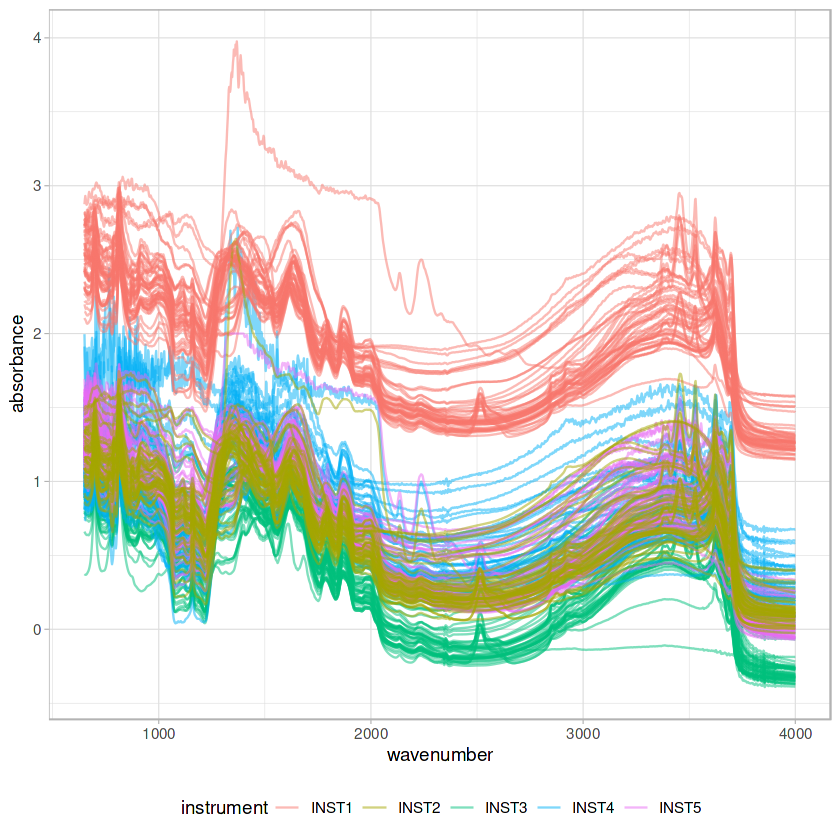

In [5]:
## Visualization
spectra.columns <- as.character(seq(650, 4000, by = 2))

test %>%
    pivot_longer(all_of(spectra.columns), names_to = "wavenumber", values_to = "absorbance") %>%
    mutate(absorbance = as.numeric(absorbance), wavenumber = as.numeric(wavenumber)) %>%
    ggplot(aes(x = wavenumber, y = absorbance, group = unique_id)) +
    geom_line(alpha = 0.5, aes(color = instrument)) +
    theme_light() + theme(legend.position = "bottom")

In [6]:
## Smoothing + SNV reprocessing
column.ids <- c("unique_id", "instrument", "sample_id")

test.prep <- test %>%
    select(-all_of(column.ids)) %>%
    as.matrix() %>%
    prospectr::savitzkyGolay(X = ., m = 0, p = 2, w = 11, delta.wav = 2) %>%
    prospectr::standardNormalVariate() %>%
    as_tibble() %>%
    bind_cols({test %>%
    select(all_of(column.ids))}, .)

test.prep %>%
    select(1:10) %>%
    glimpse()

Rows: 250
Columns: 10
$ unique_id  <chr> "U1", "U2", "U3", "U4", "U5", "U6", "U7", "U8", "U9", "U10"…
$ instrument <chr> "INST1", "INST1", "INST1", "INST1", "INST1", "INST1", "INST…
$ sample_id  <chr> "S1139", "S1239", "S1444", "S1484", "S1498", "S1603", "S180…
$ `660`      <dbl> 1.8525416, 1.7620123, 1.6029572, 1.5717409, 1.5529931, 1.56…
$ `662`      <dbl> 1.8422883, 1.7436092, 1.5820291, 1.5736143, 1.5346145, 1.55…
$ `664`      <dbl> 1.8287571, 1.7362940, 1.5635844, 1.5788033, 1.5212568, 1.54…
$ `666`      <dbl> 1.8161351, 1.7403866, 1.5494558, 1.5860902, 1.5071629, 1.52…
$ `668`      <dbl> 1.8077425, 1.7475242, 1.5396746, 1.5904322, 1.4886412, 1.50…
$ `670`      <dbl> 1.8042094, 1.7514583, 1.5329863, 1.5917035, 1.4732969, 1.49…
$ `672`      <dbl> 1.800143, 1.750236, 1.528742, 1.589201, 1.467702, 1.480898,…


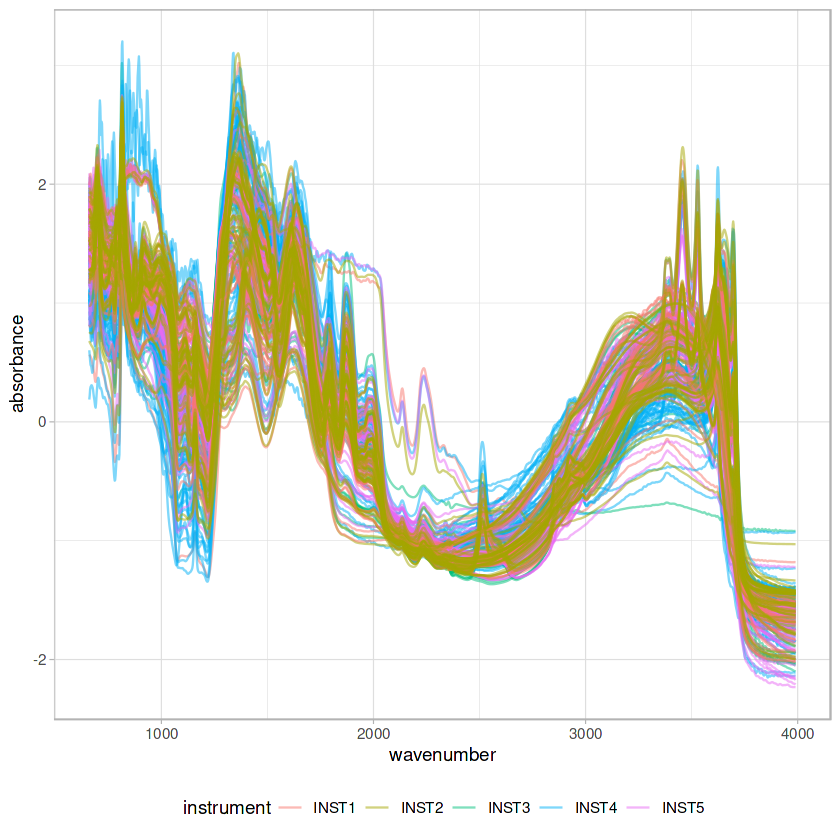

In [7]:
## Visualization
test.prep %>%
    pivot_longer(any_of(spectra.columns), names_to = "wavenumber", values_to = "absorbance") %>%
    mutate(absorbance = as.numeric(absorbance), wavenumber = as.numeric(wavenumber)) %>%
    ggplot(aes(x = wavenumber, y = absorbance, group = unique_id)) +
    geom_line(alpha = 0.5, aes(color = instrument)) +
    theme_light() + theme(legend.position = "bottom")

In [8]:
## How many samples have a texture issue?
train %>%
  mutate(texture_issue = ifelse(texture_sum >= 101, TRUE, ifelse(texture_sum <= 99, TRUE, FALSE))) %>%
  count(texture_issue)

## Which original datasets have summation issues?
train %>%
  mutate(texture_issue = ifelse(texture_sum >= 101, TRUE, ifelse(texture_sum <= 99, TRUE, FALSE))) %>%
  filter(texture_issue) %>%
  count(dataset, texture_issue)


texture_issue,n
<lgl>,<int>
FALSE,56562
TRUE,706


dataset,texture_issue,n
<chr>,<lgl>,<int>
CAF.SSL,TRUE,47
GARRETT.SSL,TRUE,53
ICRAF.ISRIC,TRUE,139
KSSL.SSL,TRUE,78
LUCAS.WOODWELL.SSL,TRUE,189
SCHIEDUNG.SSL,TRUE,194
SERBIA.SSL,TRUE,6


In [9]:
## Filtering samples
train.filtered <- train %>%
    mutate(texture_issue = ifelse(texture_sum >= 101, TRUE, ifelse(texture_sum <= 99, TRUE, FALSE))) %>%
    filter(!texture_issue)

In [10]:
## Missing observations
train.filtered %>%
    summarise(across(all_of(c("clay_perc", "sand_perc", "silt_perc")), ~sum(is.na(.))))

## Checking missing rows
train.filtered %>%
    filter(is.na(silt_perc) | is.na(sand_perc)) %>%
    select(all_of(c("clay_perc", "sand_perc", "silt_perc")))

na.ids <- train.filtered %>%
    filter(is.na(silt_perc) | is.na(sand_perc)) %>%
    pull(id)

clay_perc,sand_perc,silt_perc
<int>,<int>,<int>
0,7,7


clay_perc,sand_perc,silt_perc
<dbl>,<dbl>,<dbl>
100.00000,NA,NA
100.00000,NA,NA
99.27000,NA,0.73
96.74000,NA,3.26
97.36000,NA,2.64
1.10000,98.90,NA
1.34000,98.66,NA
0.32000,99.68,NA
100.00000,NA,NA


In [11]:
## Replacing NA with 0
train.complete.cases <- train.filtered %>%
    mutate(sand_perc = replace_na(sand_perc, 0),
           silt_perc = replace_na(silt_perc, 0))

## Checking missing rows
train.complete.cases %>%
    filter(id %in% na.ids) %>%
    select(all_of(c("clay_perc", "sand_perc", "silt_perc")))

clay_perc,sand_perc,silt_perc
<dbl>,<dbl>,<dbl>
100.00000,0.00,0.00
100.00000,0.00,0.00
99.27000,0.00,0.73
96.74000,0.00,3.26
97.36000,0.00,2.64
1.10000,98.90,0.00
1.34000,98.66,0.00
0.32000,99.68,0.00
100.00000,0.00,0.00


In [12]:
## Checking the minor summation issues
train.complete.cases %>%
    mutate(clay_perc = round(clay_perc, 2),
           sand_perc = round(sand_perc, 2)) %>%
    mutate(silt_calc = 100-(clay_perc+sand_perc)) %>%
    mutate(silt_diff = silt_perc-silt_calc) %>%
    select(silt_diff) %>%
    summary()

## We apply the correction to silt, as only clay and sand are truly determined
train.clean <- train.complete.cases %>%
    mutate(clay_perc = round(clay_perc, 2),
           sand_perc = round(sand_perc, 2)) %>%
    mutate(silt_perc = 100-(clay_perc+sand_perc)) %>%
    rowwise() %>%
    mutate(texture_sum = sum(across(c("clay_perc", "sand_perc", "silt_perc")))) %>%
    ungroup()

   silt_diff         
 Min.   :-0.9000000  
 1st Qu.:-0.0200000  
 Median : 0.0000000  
 Mean   : 0.0005376  
 3rd Qu.: 0.0200000  
 Max.   : 0.9300000  

In [13]:
## Checking if any error persists in the summation
train.clean %>%
    select(texture_sum) %>%
    summary()

  texture_sum 
 Min.   :100  
 1st Qu.:100  
 Median :100  
 Mean   :100  
 3rd Qu.:100  
 Max.   :100  

In [14]:
## Transforming compositional variables by isometric log-ratio transformation
first.ids <- train.clean[1:100,][['id']]

test <- train.clean %>%
    select(1:5) %>%
    filter(id %in% first.ids)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


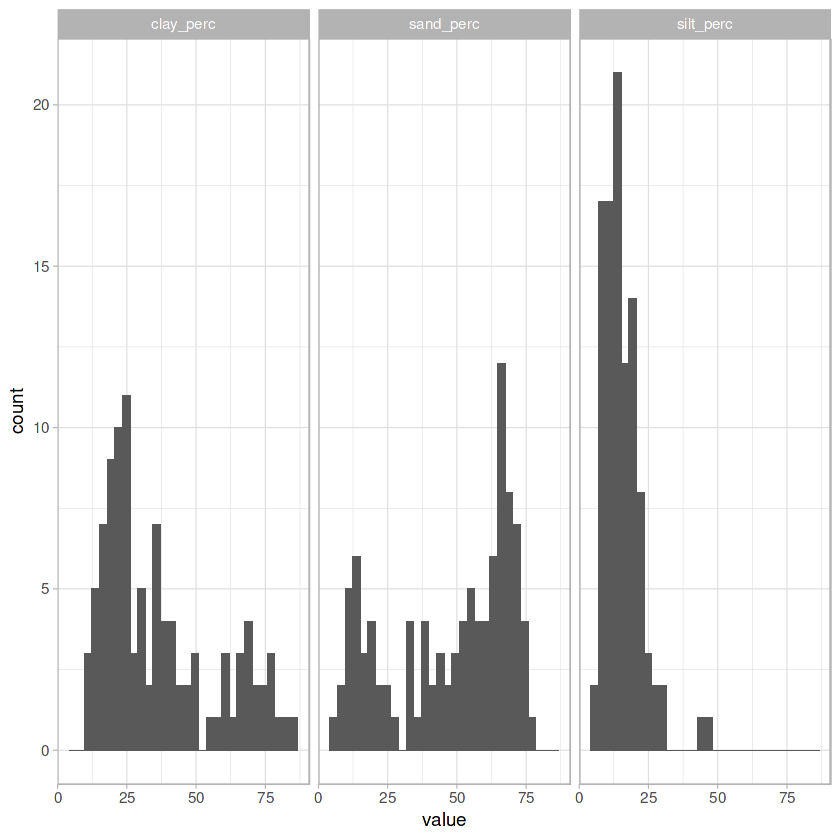

In [15]:
## Visualization - original range
test %>%
    pivot_longer(all_of(c("clay_perc", "sand_perc", "silt_perc")),
                 names_to = "soil_property", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram() + facet_wrap(~soil_property) +
    theme_light()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


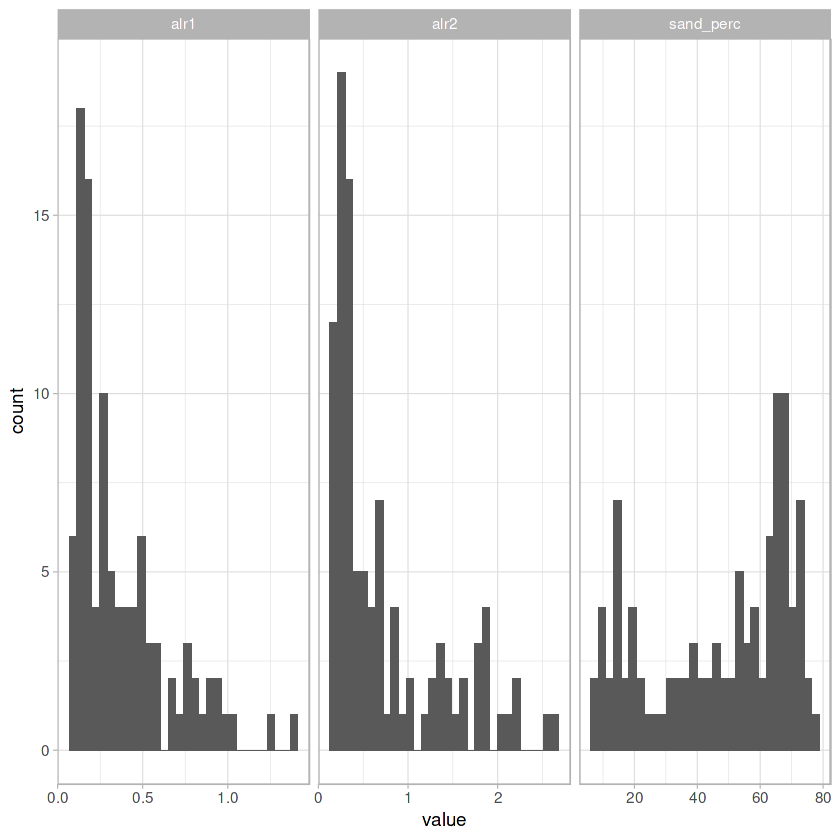

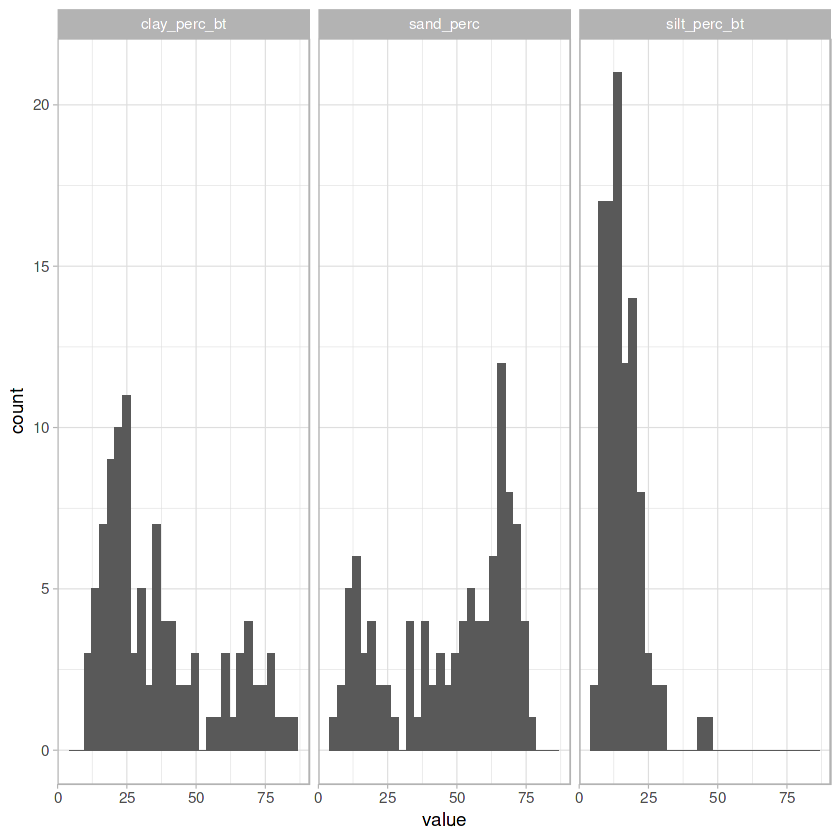

In [16]:
## Visualization of an Additive Log-Ratio Transformation
## Sand is used as the denominator
test.alr <- test %>%
    mutate(alr1 = log1p(silt_perc/sand_perc),
           alr2 = log1p(clay_perc/sand_perc))

test.alr %>%
    pivot_longer(all_of(c("sand_perc", "alr1", "alr2")),
                 names_to = "soil_property", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram() + facet_wrap(~soil_property, scale = "free_x") +
    theme_light()

test.alr.bt <- test.alr %>%
    mutate(silt_perc_bt = expm1(alr1)*sand_perc,
           clay_perc_bt = expm1(alr2)*sand_perc)

test.alr.bt %>%
    pivot_longer(all_of(c("sand_perc", "silt_perc_bt", "clay_perc_bt")),
                 names_to = "soil_property", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram() + facet_wrap(~soil_property) +
    theme_light()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


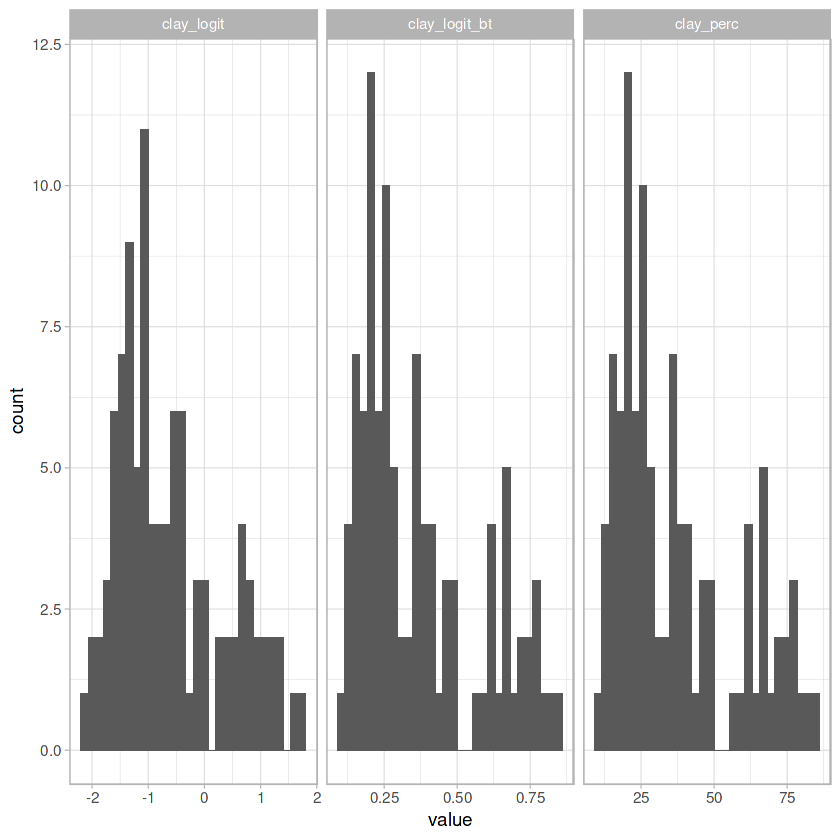

In [17]:
## Visualization of a logit function for constrained prediction to the 0-100 interval
test.logit <- test %>%
    mutate(clay = clay_perc/100) %>%
    mutate(clay_logit = log(clay/(1-clay))) %>%
    mutate(clay_logit_bt = 1/(1+exp(-clay_logit)))

test.logit %>%
    pivot_longer(all_of(c("clay_perc", "clay_logit", "clay_logit_bt")),
                 names_to = "soil_property", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram() + facet_wrap(~soil_property, scale = "free_x") +
    theme_light()


In [18]:
## Unfortunately logit does not work with PLSR because of the negative values
## ALR transformation seems to no the favorable in this situation, only clay is predicted
# train.prep <- train %>%
#     mutate(clay_logit = log((clay_perc/100)/(1-(clay_perc/100)))) %>%
#     select(clay_logit, all_of(spectra.columns))

## Apply the same preprocessing to the train set (Smoothing + SNV)
train.prep <- train %>%
    select(clay_perc, all_of(spectra.columns))

train.prep <- train.prep %>%
    select(-clay_perc) %>%
    as.matrix() %>%
    prospectr::savitzkyGolay(X = ., m = 0, p = 2, w = 11, delta.wav = 2) %>%
    prospectr::standardNormalVariate() %>%
    as_tibble() %>%
    bind_cols({train.prep %>%
    select(clay_perc)}, .)

train.prep %>%
    select(1:10) %>%
    glimpse()

Rows: 57,268
Columns: 10
$ clay_perc <dbl> 30.99, 35.06, 29.56, 35.22, 30.83, 37.13, 55.34, 67.51, 26.6…
$ `660`     <dbl> 1.2625265, 1.3091302, 1.3964446, 1.3538246, 1.2477824, 1.179…
$ `662`     <dbl> 1.2572951, 1.3073420, 1.3925311, 1.3509891, 1.2431693, 1.179…
$ `664`     <dbl> 1.2532873, 1.3065066, 1.3890064, 1.3482420, 1.2392148, 1.180…
$ `666`     <dbl> 1.2498443, 1.3064404, 1.3853220, 1.3454552, 1.2361292, 1.180…
$ `668`     <dbl> 1.2468120, 1.3069385, 1.3818334, 1.3422178, 1.2341635, 1.179…
$ `670`     <dbl> 1.2445020, 1.3073150, 1.3789535, 1.3389434, 1.2329492, 1.177…
$ `672`     <dbl> 1.2431228, 1.3075618, 1.3762116, 1.3369607, 1.2318626, 1.175…
$ `674`     <dbl> 1.2425116, 1.3082143, 1.3734907, 1.3365441, 1.2308532, 1.174…
$ `676`     <dbl> 1.2420281, 1.3090351, 1.3710075, 1.3366789, 1.2297863, 1.172…


In [19]:
## Training a base model, i.e., without HPO of the number of factors
## Generally 20 components retain 99% of the original variability with good prediction
training.outcome <- train.prep %>%
    select(clay_perc) %>%
    as.matrix()
    
training.predictors <- train.prep %>%
    select(-clay_perc) %>%
    as.matrix()

pls.training.data <- data.frame(target = I(training.outcome),
                                spectra = I(training.predictors))
    
pls.model <- plsr(target ~ spectra, data = pls.training.data, ncomp = 20,
                  scale = TRUE, center = TRUE)

In [20]:
summary(pls.model)

Data: 	X dimension: 57268 1666 
	Y dimension: 57268 1
Fit method: kernelpls
Number of components considered: 20
TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.31    55.74    62.28    71.26    78.74    83.11    86.51    90.27
target    41.88    47.39    56.86    60.35    62.99    65.94    68.39    69.73
        9 comps  10 comps  11 comps  12 comps  13 comps  14 comps  15 comps
X         91.94     94.06     95.25     95.87     96.27     96.62     96.77
target    71.49     72.78     74.07     74.85     75.68     76.35     77.18
        16 comps  17 comps  18 comps  19 comps  20 comps
X          97.36     97.72     98.01     98.25     98.43
target     77.44     77.86     78.15     78.48     78.80


In [21]:
## Predicting
test.reference <- test.prep %>%
    select(all_of(column.ids))
  
testing.predictors <- test.prep %>%
    select(any_of(spectra.columns)) %>%
    as.matrix()

pls.testing.format <- data.frame(spectra = I(testing.predictors))

predictions <- predict(pls.model, newdata = pls.testing.format) %>%
      as.data.frame() %>%
      as_tibble() %>%
      rename_with(~paste0("pred_", seq(1, 20, by=1), "comp"), everything()) %>%
      bind_cols(test.reference, .)

head(predictions)

unique_id,instrument,sample_id,pred_1comp,pred_2comp,pred_3comp,pred_4comp,pred_5comp,pred_6comp,pred_7comp,⋯,pred_11comp,pred_12comp,pred_13comp,pred_14comp,pred_15comp,pred_16comp,pred_17comp,pred_18comp,pred_19comp,pred_20comp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
U1,INST1,S1139,35.07578,38.38369,36.22399,35.97913,34.06466,41.42558,41.37371,⋯,38.69689,41.14034,38.82614,37.12799,35.28011,35.73368,35.20472,35.47906,37.30045,38.27809
U2,INST1,S1239,32.92324,34.95252,32.75252,31.72963,31.57807,37.76793,35.51673,⋯,34.32103,40.14823,38.18052,36.88177,35.03115,37.10503,36.51864,37.29522,37.60544,38.26392
U3,INST1,S1444,26.19452,22.44130,13.29968,12.65520,14.08345,18.24135,20.22782,⋯,21.24658,22.26215,24.37889,23.49078,22.73991,23.40462,24.84799,24.66266,24.87400,23.63342
U4,INST1,S1484,35.59708,33.94224,30.09777,27.80891,29.66436,31.10710,30.89868,⋯,31.10916,31.34510,32.95866,31.92264,31.93581,31.30840,31.88991,32.41053,33.01857,32.43700
U5,INST1,S1498,27.56804,23.56670,14.13105,13.27504,15.01762,18.98113,20.31409,⋯,20.79629,21.79532,23.74992,22.66516,21.65528,22.32526,23.75937,23.45801,23.35811,22.18491
U6,INST1,S1603,26.57850,22.59729,13.03530,12.03125,13.45875,17.53730,19.47681,⋯,20.38174,21.44863,23.33817,22.23800,21.31222,21.74996,22.97905,22.57794,22.62837,21.45139


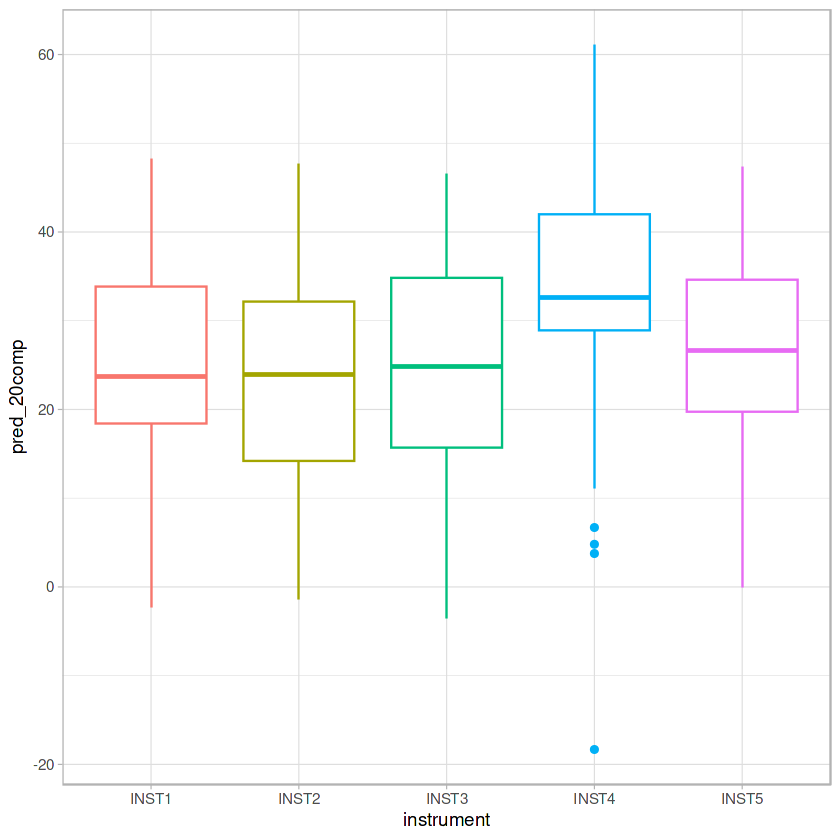

In [22]:
## General analysis of predictions
## Predictions should be similar across instruments
## i.e. have the same distribution
predictions %>%
    select(all_of(column.ids), pred_20comp) %>%
    ggplot(aes(x = instrument, y = pred_20comp)) +
    geom_boxplot(aes(color = instrument), show.legend = F) +
    theme_light()

In [23]:
## Saving to submission
submission <- predictions %>%
    select(unique_id, pred_20comp) %>%
    rename(clay_perc = pred_20comp)

head(submission)

write_csv(submission, "submission.csv")

unique_id,clay_perc
<chr>,<dbl>
U1,38.27809
U2,38.26392
U3,23.63342
U4,32.43700
U5,22.18491
U6,21.45139
